## MICCAI SCM Baseline

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-01-27 21:19:16.707508: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-27 21:19:17.023067: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-27 21:19:18.099926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *

In [8]:
# overall imports
import importlib
import data

from sim.sim import Simulation
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run, open_pickled_results

# data load
import data.data_utils
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_shared_matrices,
    process_cv_splits,  
    expanded_inner_folds_combined_plus_indices
)

import models
import models.metrics
from models.metrics import *

In [5]:
print_system_usage()
total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 8.5%
RAM Usage: 6.2%
Available RAM: 353.6G
Total RAM: 377.1G
52.4G


## Specify connectome and transcriptome

Full brain HCP Enigma

In [6]:
hemisphere = 'both'
PCA = True

HCP_enigma_structural_count, HCP_enigma_labels, HCP_enigma_lh_indices, HCP_enigma_rh_indices = load_connectome(measure='SC', omit_subcortical=False, include_labels=True, diag=0, hemisphere=hemisphere)
HCP_enigma_functional_conn = load_connectome(measure='FC', omit_subcortical=False, hemisphere=hemisphere)
HCP_coords = load_coords(parcellation='S100', omit_subcortical=False, hemisphere=hemisphere)
HCP_coords_left = load_coords(parcellation='S100', omit_subcortical=False, hemisphere='left')
HCP_coords_right = load_coords(parcellation='S100', omit_subcortical=False, hemisphere='right')
AHBAS100_transcriptome = load_transcriptome(parcellation='S100', omit_subcortical=False, hemisphere=hemisphere, run_PCA=PCA)

Number of components for 95% variance PCA: 34


Full brain HCP1200 and UKBB

In [7]:
hemisphere = 'left' # single hemisphere run is tractable within 2 minutes for closed form solution
PCA = True

HCP1200_structural_count, HCP1200_labels, HCP1200_lh_indices, HCP1200_rh_indices = load_connectome(measure='SC', parcellation='S400', omit_subcortical=False, include_labels=True)
HCP1200_functional_conn = load_connectome(measure='FC', parcellation='S400', omit_subcortical=False)
HCP1200_coords = load_coords(parcellation='S400', omit_subcortical=False)
AHBAS400_transcriptome = load_transcriptome(parcellation='S400', omit_subcortical=False, run_PCA=PCA)

# Find rows that are all NaN - there are 66 regions that are unsampled, and 9 cerebellar regions that are not assigned to hemispheres
nan_rows = np.isnan(AHBAS400_transcriptome).all(axis=1)
nan_row_indices = np.where(nan_rows)[0]
print(f"Original shape of AHBAS400_transcriptome: {AHBAS400_transcriptome.shape}")

# Get valid indices for left and right hemispheres by excluding NaN rows
valid_left_indices = [i for i in HCP1200_lh_indices if i not in nan_row_indices]
valid_right_indices = [i for i in HCP1200_rh_indices if i not in nan_row_indices]

if hemisphere == 'left':
    valid_indices = valid_left_indices
elif hemisphere == 'right':
    valid_indices = valid_right_indices
else: # Combine valid indices from both hemispheres
    valid_indices = valid_left_indices + valid_right_indices

# Subset transcriptome and connectomes to only include valid regions
AHBAS400_transcriptome = AHBAS400_transcriptome[valid_indices]
HCP1200_structural_count = HCP1200_structural_count[valid_indices][:, valid_indices]
HCP1200_functional_conn = HCP1200_functional_conn[valid_indices][:, valid_indices]
print(f"Shape of transcriptome after removing NaN regions: {AHBAS400_transcriptome.shape}")
print(f"Contains NaN values: {np.isnan(AHBAS400_transcriptome).any()}")
print("Shape of HCP1200_structural_count: ", HCP1200_structural_count.shape)
print("Shape of HCP1200_functional_conn: ", HCP1200_functional_conn.shape)

Number of components for 95% variance PCA: 105
Original shape of AHBAS400_transcriptome: (456, 105)
Shape of transcriptome after removing NaN regions: (214, 105)
Contains NaN values: False
Shape of HCP1200_structural_count:  (214, 214)
Shape of HCP1200_functional_conn:  (214, 214)


Assign features and targets

In [13]:
### S100 ###
X = AHBAS100_transcriptome
Y_sc = HCP_enigma_structural_count
Y_fc = HCP_enigma_functional_conn
Y = Y_fc
left_coords = HCP_coords_left
right_coords = HCP_coords_right

# ### S400 ###
# X = AHBAS400_transcriptome
# Y_sc = HCP1200_structural_count
# Y_fc = HCP1200_functional_conn
# Y = Y_sc
# left_coords = HCP1200_coords[valid_left_indices]
# right_coords = HCP1200_coords[valid_right_indices]

# Print shapes of feature and target matrices
print("Feature matrix X shape:", X.shape)
print("Structural connectivity Y_sc shape:", Y_sc.shape) 
print("Functional connectivity Y_fc shape:", Y_fc.shape)
print("Target matrix Y shape:", Y.shape)
print("Left coordinates shape:", left_coords.shape)
print("Right coordinates shape:", right_coords.shape)


Feature matrix X shape: (114, 34)
Structural connectivity Y_sc shape: (114, 114)
Functional connectivity Y_fc shape: (114, 114)
Target matrix Y shape: (114, 114)
Left coordinates shape: (57, 3)
Right coordinates shape: (57, 3)


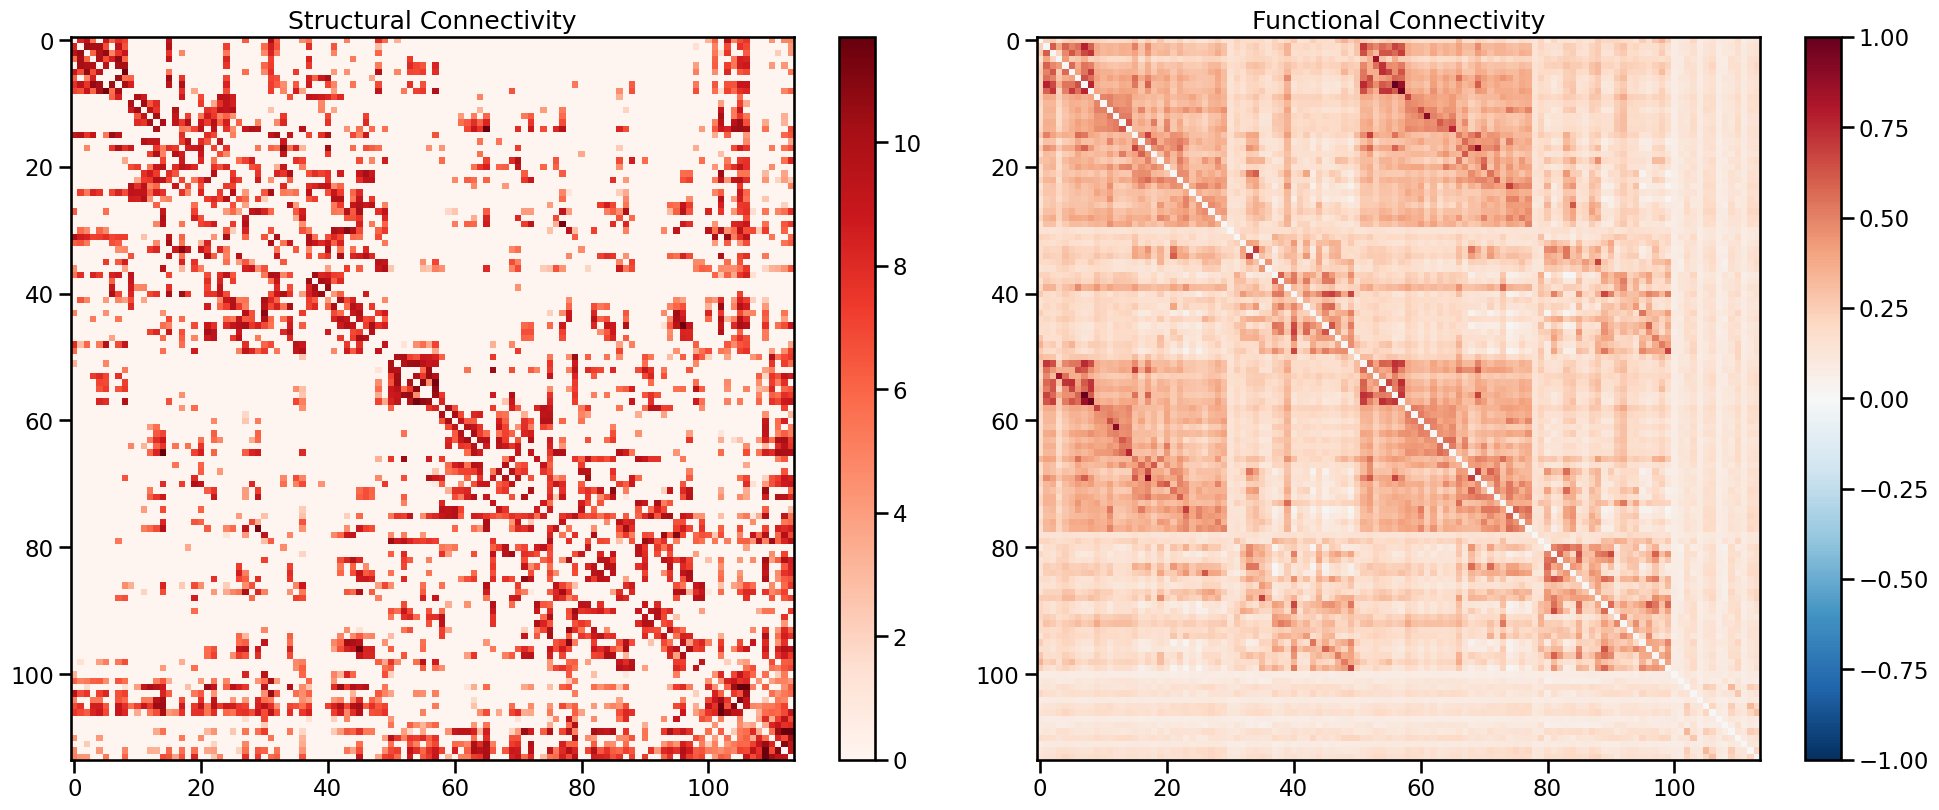

In [14]:
# Visualize structural and functional connectivity matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

im1 = ax1.imshow(Y_sc, cmap='Reds')
ax1.set_title('Structural Connectivity')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(Y_fc, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Functional Connectivity') 
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


## Fit SCM model

X shape: (114, 34)
K shape after Kronecker: (12996, 1156)
Y shape before flatten: (114, 114)
Y_flat shape: (12996,)
K_transpose_K shape: (1156, 1156)
K_reg shape: (1156, 1156)
K_pseudo_inv shape: (1156, 12996)
O_flat shape: (1156,)
Residuals shape: (12996,)
K_proj shape: (12996, 12996)
tau: 11840.0
objective: 5.900451820749322e-06

SCM model metrics:
Pearson r: 0.415
R-squared: -3.27250
MSE: 0.06365


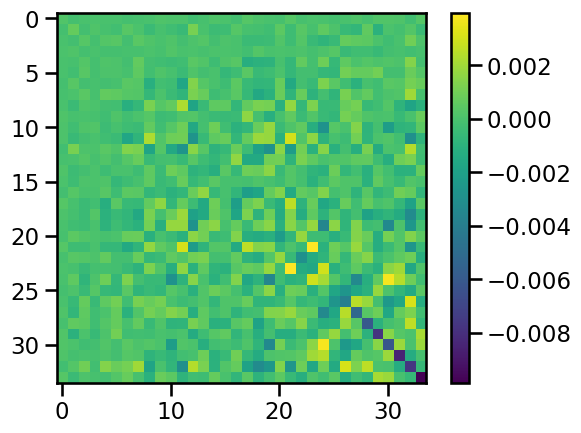

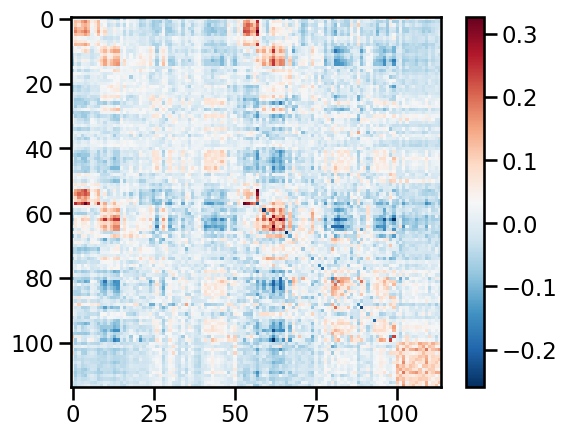

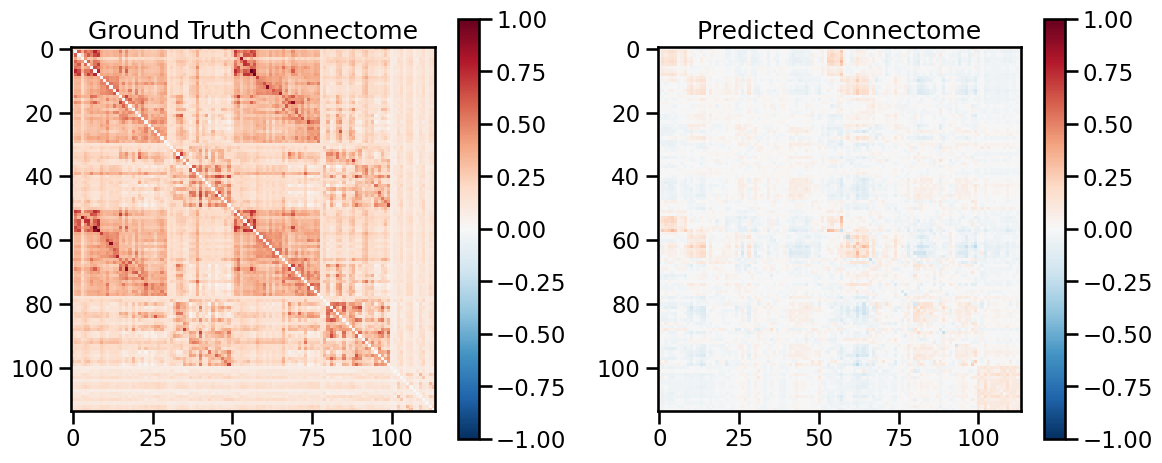

In [15]:
# Adapted from https://github.com/kpisti/SCM/tree/v1.0. Below implementation is aligned with Ridge Regression model from full paper.
def fit_scm(X, Y, alpha=0.0, verbose=True):
    """
    Fit Structural Covariance Model (SCM) to predict connectivity from gene expression.
    
    Args:
        X: Gene expression PCA matrix (regions x gene_PCA_dim)
        Y: Connectivity matrix (regions x regions) 
        alpha: Regularization parameter for ridge regression
        
    Returns:
        O: Estimated rule matrix (gene_PCA_dim x gene_PCA_dim)
        Y_pred: Predicted connectivity matrix (regions x regions)
        objective: Objective function value
    """
    # Compute Kronecker product of X with itself to obtain K matrix
    if verbose: print(f"X shape: {X.shape}")
    K = np.kron(X, X)  
    if verbose: print(f"K shape after Kronecker: {K.shape}")
    
    # Flatten connectivity matrix Y
    if verbose: print(f"Y shape before flatten: {Y.shape}")
    Y_flat = Y.flatten() 
    if verbose: print(f"Y_flat shape: {Y_flat.shape}")
    
    # Compute K transpose multiplied by K
    K_transpose_K = np.dot(K.T, K) 
    if verbose: print(f"K_transpose_K shape: {K_transpose_K.shape}")
    
    # Add regularization term
    # K_transpose_K /= np.linalg.norm(K_transpose_K)
    K_reg = K_transpose_K + alpha * np.identity(K_transpose_K.shape[0]) 
    if verbose: print(f"K_reg shape: {K_reg.shape}")

    # Compute the pseudo-inverse solution
    K_pseudo_inv = np.linalg.pinv(K_reg).dot(K.T)
    if verbose: print(f"K_pseudo_inv shape: {K_pseudo_inv.shape}")
    
    # Estimate the rule matrix in vectorized form
    O_flat = K_pseudo_inv.dot(Y_flat)
    if verbose: print(f"O_flat shape: {O_flat.shape}")
    
    # Compute residuals and objective
    residuals = Y_flat - np.dot(K, O_flat)
    if verbose: print(f"Residuals shape: {residuals.shape}")
    residual_norm = np.linalg.norm(residuals)

    K_proj = np.dot(K, K_pseudo_inv)
    if verbose: print(f"K_proj shape: {K_proj.shape}")
    
    tau = np.trace(np.identity(K_proj.shape[0]) - K_proj)
    if verbose: print(f"tau: {tau}")
    
    objective = residual_norm*residual_norm/tau/tau # ** 2)
    if verbose: print(f"objective: {objective}")
    
    # Reshape O to original dimensions
    O = O_flat.reshape(X.shape[1], X.shape[1])
    
    # Predict connectivity matrix
    Y_pred = np.dot(X, np.dot(O, X.T))
    
    # Min-max scale Y_pred to [-1,1] range
    return O, Y_pred, objective

# Fit the default unregularized model
O, Y_pred, objective = fit_scm(X, Y)

# Flatten matrices for calculations
y_true = Y.flatten()
y_pred = Y_pred.flatten()

# Metrics
pearson_r, _ = stats.pearsonr(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print("\nSCM model metrics:")
print(f"Pearson r: {pearson_r:.3f}")
print(f"R-squared: {r2:.5f}") 
print(f"MSE: {mse:.5f}")

plt.imshow(O)
plt.colorbar()
plt.show()

im = plt.imshow(Y_pred, cmap='RdBu_r')
plt.colorbar(im)
plt.show()

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth connectome
im1 = ax1.imshow(Y, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_title('Ground Truth Connectome')
plt.colorbar(im1, ax=ax1)

# Plot predicted connectome  
im2 = ax2.imshow(Y_pred, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Predicted Connectome')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()



0 - 5.900451820749322e-06
0.001 - 5.900451707966906e-06
0.01 - 5.900450692928215e-06
0.1 - 5.900440542844887e-06
1 - 5.900339072356103e-06
10 - 5.899327389074469e-06
100 - 5.889500489929132e-06
1000 - 5.8119932178420455e-06


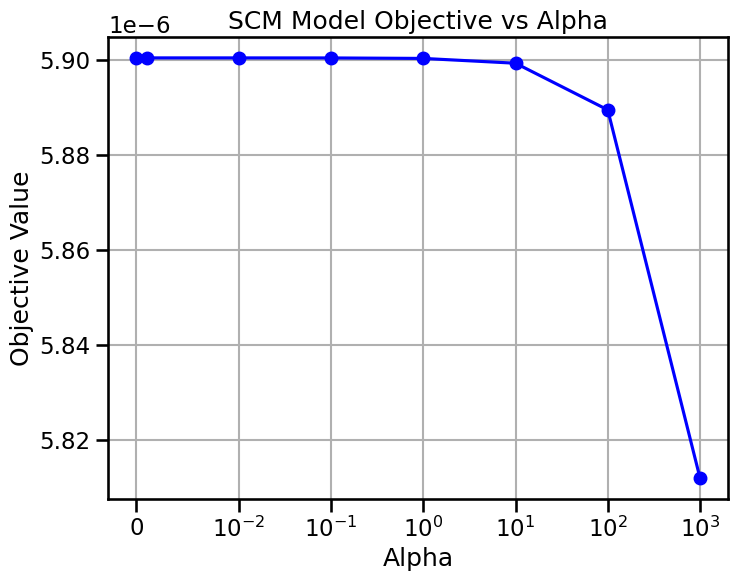

In [16]:
def grid_search_alpha(X, Y, alpha_values):
    objectives = []
    for alpha in alpha_values:
        _, _, obj = fit_scm(X, Y, alpha=alpha, verbose=False)
        print(alpha, '-',  obj)
        objectives.append(obj)
    
    # Plot alpha vs objective
    plt.figure(figsize=(8, 6))
    plt.plot(alpha_values, objectives, 'bo-')
    plt.xscale('symlog', linthresh=0.01)  # Log scale that handles 0
    plt.xlabel('Alpha')
    plt.ylabel('Objective Value') 
    plt.title('SCM Model Objective vs Alpha')
    plt.grid(True)
    plt.show()
    
    return alpha_values, objectives

# Run grid search
#alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
alphas = [0, 0.001, 0.01, 0.1, 1, 10, 10**2, 10**3]
alpha_values, objectives = grid_search_alpha(X, Y, alphas)


permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
hemisphere:  both
rotated_ids shape: (114, 1000)
permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950


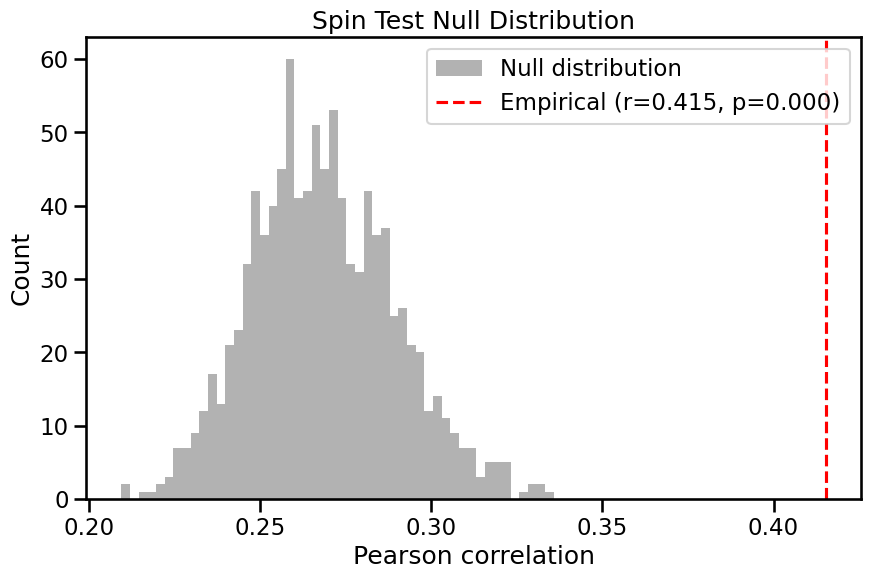

In [17]:
def run_spin_test(X, Y_true, left_coords, right_coords, hemisphere, n_perms=100, shuffle_target=True):
    """
    Run spin test permutation analysis for SCM model
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Input transcriptome data
    Y_true : array-like of shape (n_samples, n_samples) 
        Input connectome data
    left_coords : array-like
        Left hemisphere coordinates
    right_coords : array-like  
        Right hemisphere coordinates
    n_perms : int, default=100
        Number of permutations for null distribution
    shuffle_target : bool, default=True
        If True, shuffle connectome (Y). If False, shuffle transcriptome (X)
        
    Returns:
    --------
    empirical_corr : float
        Empirical correlation
    p_value : float
        P-value from permutation test
    null_corrs : array
        Null distribution correlations
    """
    # Calculate empirical correlation
    O, Y_pred, _ = fit_scm(X, Y_true, verbose=False)
    empirical_corr = stats.pearsonr(Y_true.flatten(), Y_pred.flatten())[0]

    # Generate all rotations beforehand
    rotated_ids = rotate_parcellation(left_coords, right_coords, nrot=n_perms)
    rotated_ids = rotated_ids.astype(int)
    
    print('hemisphere: ', hemisphere)
    if hemisphere == 'left':
        rotated_ids = rotated_ids[:len(left_coords)]
    elif hemisphere == 'right':
        rotated_ids = rotated_ids[len(left_coords):]

    print(f"rotated_ids shape: {rotated_ids.shape}")
    # Initialize array to store null correlations
    null_corrs = np.zeros(n_perms)

    # Generate null distribution
    for i in range(n_perms):
        if i % 50 == 0:
            print(f"permutation: {i}")
        perm_ids = rotated_ids[:, i]
        
        if shuffle_target: # Shuffle connectome
            Y_rotated = Y_true[perm_ids][:, perm_ids]
            X_rotated = X
        else: # Shuffle transcriptome   
            Y_rotated = Y_true
            X_rotated = X[perm_ids]
        
        # Fit SCM on rotated data
        O_null, Y_pred_null, _ = fit_scm(X_rotated, Y_rotated, verbose=False)
        
        # Calculate correlation
        null_corrs[i] = stats.pearsonr(Y_rotated.flatten(), Y_pred_null.flatten())[0]

    # Calculate p-value
    p_value = np.mean(null_corrs >= empirical_corr)

    # Plot null distribution
    plt.figure(figsize=(10, 6))
    plt.hist(null_corrs, bins=50, alpha=0.6, color='gray', label='Null distribution')
    plt.axvline(empirical_corr, color='red', linestyle='--', 
                label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
    plt.xlabel('Pearson correlation')
    plt.ylabel('Count')
    plt.title('Spin Test Null Distribution')
    plt.legend()
    plt.show()
    
    return empirical_corr, p_value, null_corrs

# Run the spin test
empirical_corr, p_value, null_distribution = run_spin_test(
    X=X,
    Y_true=Y,
    left_coords=left_coords,
    right_coords=right_coords,
    hemisphere='both',
    n_perms=1000,
    shuffle_target=False
)


### Pytorch SCM model

In [89]:
from models.bilinear import BilinearSCM  # using gradient based optimization

X_expanded = expand_X_symmetric(X) # PCA version
Y_expanded = expand_Y_symmetric(Y)
print('X_expanded.shape: ', X_expanded.shape)
print('Y_expanded.shape: ', Y_expanded.shape)

scm_torch_model = BilinearSCM(input_dim=X_expanded.shape[1], learning_rate=0.0003, epochs=200, 
                 batch_size=400, regularization='l2', lambda_reg=0.0, bias=True)

scm_torch_model.fit(X_expanded, Y_expanded)
Y_pred = scm_torch_model.predict(X_expanded)


X_expanded.shape:  (12882, 68)
Y_expanded.shape:  (12882,)
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/200, Train Loss: 80.5405
Epoch 20/200, Train Loss: 22.8126
Epoch 30/200, Train Loss: 7.9438
Epoch 40/200, Train Loss: 3.3169
Epoch 50/200, Train Loss: 1.5111
Epoch 60/200, Train Loss: 0.7016
Epoch 70/200, Train Loss: 0.3325
Epoch 80/200, Train Loss: 0.1576
Epoch 90/200, Train Loss: 0.0789
Epoch 100/200, Train Loss: 0.0431
Epoch 110/200, Train Loss: 0.0264
Epoch 120/200, Train Loss: 0.0189
Epoch 130/200, Train Loss: 0.0155
Epoch 140/200, Train Loss: 0.0139
Epoch 150/200, Train Loss: 0.0129
Epoch 160/200, Train Loss: 0.0123
Epoch 170/200, Train Loss: 0.0121
Epoch 180/200, Train Loss: 0.0120
Epoch 190/200, Train Loss: 0.0121
Epoch 200/200, Train Loss: 0.0121


Bilinear layer weights shape: (1, 34, 34)

Bilinear weights:
[[[ 1.85325669e-04 -1.38754564e-04 -6.18835838e-05 ...  1.72375949e-04
   -2.17874753e-04  4.15360759e-04]
  [-1.45195925e-04  8.25713796e-04 -1.55404530e-04 ... -1.74972738e-04
    1.98241745e-04 -5.11445629e-04]
  [ 5.23371564e-05 -1.24381928e-04  6.81274803e-04 ...  1.11170826e-04
    1.09083834e-03 -1.56142836e-04]
  ...
  [ 1.12799280e-04  4.88832702e-05  3.69725567e-05 ... -4.10902576e-04
   -5.55238861e-04  9.32919036e-04]
  [-6.87928259e-05  2.50182842e-04  1.09708251e-03 ... -9.84740094e-04
    3.69766407e-04 -3.58578109e-04]
  [ 2.60951521e-04 -4.04425693e-04  2.95513019e-05 ...  5.23412193e-04
    1.23004385e-04  6.50426198e-04]]]

Bilinear bias:
[0.22917692]


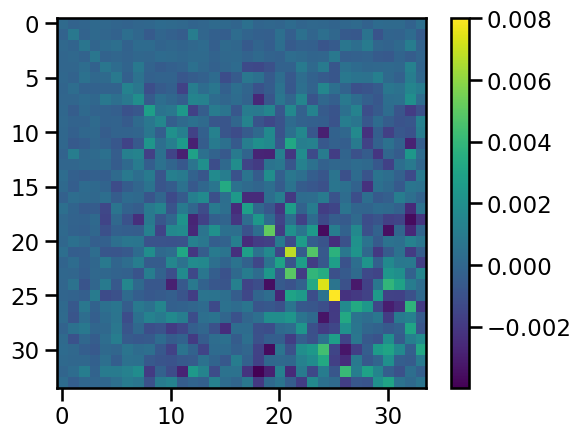

In [90]:
# Get bilinear layer weights
bilinear_weights = scm_torch_model.bilinear.weight.detach().cpu().numpy()
bilinear_bias = scm_torch_model.bilinear.bias.detach().cpu().numpy()

print("Bilinear layer weights shape:", bilinear_weights.shape)
print("\nBilinear weights:")
print(bilinear_weights)
print("\nBilinear bias:")
print(bilinear_bias)

plt.imshow(bilinear_weights.reshape(bilinear_weights.shape[-2], bilinear_weights.shape[-1]))
plt.colorbar()
plt.show()


In [91]:
# Calculate metrics
pearson = stats.pearsonr(Y_expanded, Y_pred)[0]
mse = np.mean((Y_expanded - Y_pred)**2)
r2 = r2_score(Y_expanded, Y_pred)
print(f"Pearson correlation: {pearson:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R2 score: {r2:.3f}")

Y_pred = reconstruct_connectome(Y_pred)

Pearson correlation: 0.446
MSE: 0.012
R2 score: 0.199


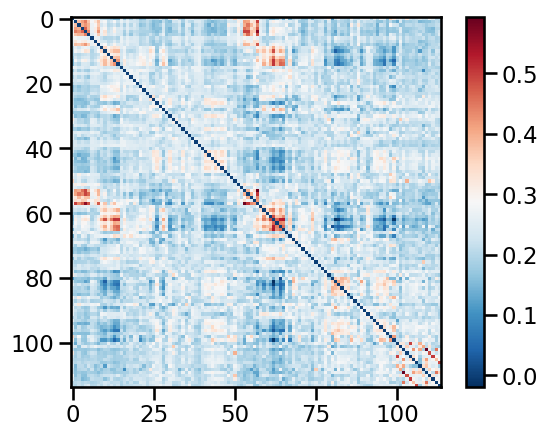

In [92]:
im = plt.imshow(Y_pred, cmap='RdBu_r')
plt.colorbar(im)
plt.show()

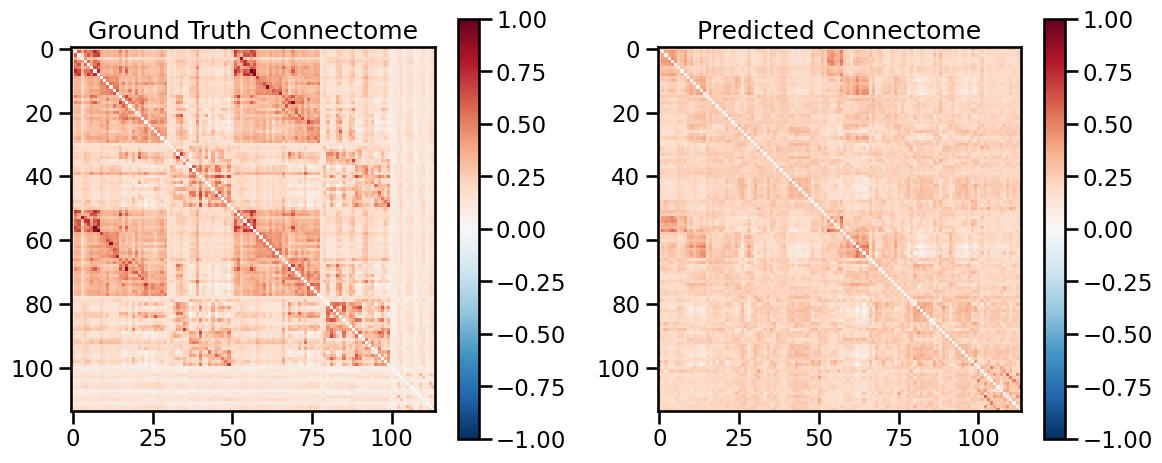

In [93]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth connectome
im1 = ax1.imshow(Y, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_title('Ground Truth Connectome')
plt.colorbar(im1, ax=ax1)

# Plot predicted connectome  
im2 = ax2.imshow(Y_pred, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Predicted Connectome')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

### Run a train test split for the SCM model

In [ ]:
# Run simulation
single_sim_run(
              cv_type='random',
              random_seed=42,
              model_type='bilinear_SCM',
              feature_type=[{'transcriptome': 'PCA'}],
              connectome_target='FC',
              use_gpu=True,
              use_shared_regions=False,
              test_shared_regions=False,
              omit_subcortical=False,
              parcellation='S100',
              gene_list='0.2',
              hemisphere='both',
              search_method=('wandb', 'mse', 20),
              save_sim=False,
              track_wandb=True,
              skip_cv=False
              )

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
# Clear CPU memory
gc.collect()

Number of components for 95% variance PCA: 34
X shape: (114, 10760)
X_pca shape: (114, 34)
Y_sc shape: (114, 114)
Y_sc_spectralL shape: (114, 113)
Y_sc_spectralA shape: (114, 114)
Y_fc shape: (114, 114)
Coordinates shape: (114, 3)
Y shape (114, 114)
feature_name:  transcriptome
processing_type:  PCA
X shape (114, 34)

 Test fold num: 1 X_train shape: (7140, 68) Y_train shape: (7140,) X_test shape: (812, 68) Y_test shape: (812,)


  return LooseVersion(v) >= LooseVersion(check)

ERROR: Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: asratzan (alexander-ratzan-new-york-university). Use `wandb login --relogin` to force relogin


2
3
4


wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. Additional properties are not allowed ('best_parameters' was unexpected)


Create sweep with ID: 1aecuasa
Sweep URL: https://wandb.ai/alexander-ratzan-new-york-university/gx2conn/sweeps/1aecuasa


wandb: Agent Starting Run: i2e5rni5 with config:
wandb: 	batch_size: 260
wandb: 	epochs: 230
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.14210742936609308
wandb: 	learning_rate: 0.0005503513690428881
wandb: 	regularization: l2
ERROR: Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157


  warnings.warn(



Epoch 10/230, Train Loss: 100.7545, Val Loss: 126.9378
Epoch 20/230, Train Loss: 41.0513, Val Loss: 77.1756
Epoch 30/230, Train Loss: 20.1693, Val Loss: 58.7604
Epoch 40/230, Train Loss: 11.8715, Val Loss: 43.0349


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 50/230, Train Loss: 7.8506, Val Loss: 37.9131
Epoch 60/230, Train Loss: 5.5314, Val Loss: 31.8340
Epoch 70/230, Train Loss: 4.0943, Val Loss: 25.1187
Epoch 80/230, Train Loss: 3.1478, Val Loss: 25.9241
Epoch 90/230, Train Loss: 2.4999, Val Loss: 23.5211
Epoch 100/230, Train Loss: 2.0301, Val Loss: 16.3040
Epoch 110/230, Train Loss: 1.6812, Val Loss: 15.1546
Epoch 120/230, Train Loss: 1.4172, Val Loss: 14.0076
Epoch 130/230, Train Loss: 1.2005, Val Loss: 12.6324
Epoch 140/230, Train Loss: 1.0304, Val Loss: 10.1506
Epoch 150/230, Train Loss: 0.8913, Val Loss: 10.1014
Epoch 160/230, Train Loss: 0.7748, Val Loss: 8.3792
Epoch 170/230, Train Loss: 0.6768, Val Loss: 7.4583
Epoch 180/230, Train Loss: 0.5928, Val Loss: 5.9997
Epoch 190/230, Train Loss: 0.5233, Val Loss: 6.2698
Epoch 200/230, Train Loss: 0.4621, Val Loss: 5.2997
Epoch 210/230, Train Loss: 0.4092, Val Loss: 4.3301
Epoch 220/230, Train Loss: 0.3635, Val Loss: 4.0163
Epoch 230/230, Train Loss: 0.3235, Val Loss: 3.5483
Proces

  from IPython.core.display import HTML, display  # type: ignore



fold0_epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▆▆▆▆▆▆▆▇▇▇▇▇███
fold0_train_loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▂▃▃▃▃▃▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▆▅▆▆▇▇▇▇▇█
fold0_val_loss,█▆▄▄▅▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▂▅▁▄▄▁▃▅▁▂▃▂█▂▃▇▂▁▆▃▆▄▃▄▃▅▄▇▂▅▅▆▄█▅▃▆▃▅▅
fold1_epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█████
fold1_train_loss,█▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▂▃▂▂▂▂▂▂▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▆▅▅▆▇▇████
fold1_val_loss,█▇▆▆▆▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
fold1_val_pearson,▁▂▂▂▃▃▃▄▃▃▄▃▃▅▄▄▃▅▅▆▆█▄▆▇█▆▇▇▅▆▇███▇██▇▆
fold2_epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jyudasf4 with config:
wandb: 	batch_size: 372
wandb: 	epochs: 215
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.003870786985288156
wandb: 	learning_rate: 0.001013210808359246
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/215, Train Loss: 47.4314, Val Loss: 49.2639
Epoch 20/215, Train Loss: 14.7240, Val Loss: 40.9613
Epoch 30/215, Train Loss: 6.5488, Val Loss: 20.0967
Epoch 40/215, Train Loss: 3.6741, Val Loss: 19.6003
Epoch 50/215, Train Loss: 2.4157, Val Loss: 15.1565
Epoch 60/215, Train Loss: 1.6958, Val Loss: 10.1454


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 70/215, Train Loss: 1.2442, Val Loss: 10.6048
Epoch 80/215, Train Loss: 0.9320, Val Loss: 8.7574
Epoch 90/215, Train Loss: 0.7190, Val Loss: 6.9964
Epoch 100/215, Train Loss: 0.5699, Val Loss: 6.2835
Epoch 110/215, Train Loss: 0.4581, Val Loss: 5.6956
Epoch 120/215, Train Loss: 0.3763, Val Loss: 5.3559
Epoch 130/215, Train Loss: 0.3019, Val Loss: 4.9948
Epoch 140/215, Train Loss: 0.2588, Val Loss: 4.7617
Epoch 150/215, Train Loss: 0.2111, Val Loss: 4.0341
Epoch 160/215, Train Loss: 0.1792, Val Loss: 3.0943
Epoch 170/215, Train Loss: 0.1519, Val Loss: 3.9212
Epoch 180/215, Train Loss: 0.1297, Val Loss: 2.9608
Epoch 190/215, Train Loss: 0.1112, Val Loss: 3.2036
Epoch 200/215, Train Loss: 0.0969, Val Loss: 2.3192
Epoch 210/215, Train Loss: 0.0843, Val Loss: 2.6458
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/215, Train Loss: 86.8148, Val Loss: 86.0775
Epoch 20/215, Train Loss: 24.4242, Val Loss: 102.5193
Epoch 30/215, Train Loss: 10.723

fold0_epoch,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
fold0_train_loss,█▆▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▃▃▂▃▃▃▃▂▂▁▁▁▂▁▂▂▃▃▃▃▃▃▃▃▄▃▄▄▄▄▅▄▅▆▇▇▇▇▇█
fold0_val_loss,█▇▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▃▆▅▅▆▄▄▇▅▇▇▃▆▆▆▆▆▅▂▂▅▂▄▂▃▄▃█▄▁▆▄▁▄▄▆▃▄▆▅
fold1_epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
fold1_train_loss,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▂▂▂▂▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▇▇▇▇▇██████
fold1_val_loss,█▅█▄▆▆▄▃▄▃▂▃▂▂▄▂▂▂▃▂▂▂▂▂▁▃▁▂▃▂▂▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▄▅▂▃▇▇▂▆▃▁█▆█▅▄▅▅▄█▇▅▃▃▄███▇▄▂▅▃▃▇▃▃▇▆▆▆
fold2_epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇███


wandb: Agent Starting Run: 6qze4rjn with config:
wandb: 	batch_size: 475
wandb: 	epochs: 167
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.0017420186203956805
wandb: 	learning_rate: 0.0012302882301645707
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/167, Train Loss: 68.7106, Val Loss: 87.4633
Epoch 20/167, Train Loss: 20.1146, Val Loss: 47.2174
Epoch 30/167, Train Loss: 8.4932, Val Loss: 32.0709
Epoch 40/167, Train Loss: 4.7570, Val Loss: 22.9009


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 50/167, Train Loss: 3.0629, Val Loss: 16.9607
Epoch 60/167, Train Loss: 2.1297, Val Loss: 14.6868
Epoch 70/167, Train Loss: 1.5275, Val Loss: 11.4103
Epoch 80/167, Train Loss: 1.1448, Val Loss: 9.7376
Epoch 90/167, Train Loss: 0.8754, Val Loss: 7.9721
Epoch 100/167, Train Loss: 0.6892, Val Loss: 6.8358
Epoch 110/167, Train Loss: 0.5505, Val Loss: 5.9742
Epoch 120/167, Train Loss: 0.4414, Val Loss: 5.2129
Epoch 130/167, Train Loss: 0.3549, Val Loss: 4.6111
Epoch 140/167, Train Loss: 0.2883, Val Loss: 4.0817
Epoch 150/167, Train Loss: 0.2474, Val Loss: 3.5710
Epoch 160/167, Train Loss: 0.2050, Val Loss: 3.2931
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/167, Train Loss: 27.5127, Val Loss: 85.4248
Epoch 20/167, Train Loss: 8.6964, Val Loss: 64.9256
Epoch 30/167, Train Loss: 4.2902, Val Loss: 52.2474
Epoch 40/167, Train Loss: 2.6469, Val Loss: 46.6584
Epoch 50/167, Train Loss: 1.8084, Val Loss: 40.7509
Epoch 60/167, Train Loss: 1.3201, 

fold0_epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇██
fold0_train_loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▇▇▅▅▃▁▂▁▂▁▁▂▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▆▅▆▆▆▇▇▇██
fold0_val_loss,█▇▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,█▇▅▂▂▁▂▂▄▃▃▅▂▄▃▂▃▃▃▃▃▃▄▄▃▄▄▄▄▃▄▃▃▄▄▄▄▄▃▄
fold1_epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
fold1_train_loss,█▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇██
fold1_val_loss,██▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▂▁▁▂▂▃▃▅▄▃▄▄▄▄▅▄▄▅▅▄▄▅▆▅▇▅▅▄▆▇▆▆▆▇▆▇▇▇█▇
fold2_epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h072y2nx with config:
wandb: 	batch_size: 512
wandb: 	epochs: 181
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.1084839452860318
wandb: 	learning_rate: 0.0005747923681180226
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/181, Train Loss: 141.0612, Val Loss: 180.0222
Epoch 20/181, Train Loss: 107.5574, Val Loss: 149.8588
Epoch 30/181, Train Loss: 54.6470, Val Loss: 116.7555
Epoch 40/181, Train Loss: 43.0189, Val Loss: 102.9765


  transposed = list(zip(*batch))  # It may be accessed twice, so we use a list.



Epoch 50/181, Train Loss: 26.9459, Val Loss: 89.0706
Epoch 60/181, Train Loss: 20.5168, Val Loss: 75.5063
Epoch 70/181, Train Loss: 21.2460, Val Loss: 74.4239
Epoch 80/181, Train Loss: 13.7870, Val Loss: 62.6009
Epoch 90/181, Train Loss: 11.4781, Val Loss: 57.8863
Epoch 100/181, Train Loss: 10.5060, Val Loss: 51.8603
Epoch 110/181, Train Loss: 8.0371, Val Loss: 50.0436
Epoch 120/181, Train Loss: 8.0866, Val Loss: 43.6431
Epoch 130/181, Train Loss: 6.1442, Val Loss: 40.3354
Epoch 140/181, Train Loss: 5.8597, Val Loss: 39.9398
Epoch 150/181, Train Loss: 5.3821, Val Loss: 33.8746
Epoch 160/181, Train Loss: 4.4463, Val Loss: 29.6802
Epoch 170/181, Train Loss: 4.1028, Val Loss: 32.2413
Epoch 180/181, Train Loss: 3.3348, Val Loss: 26.2263
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/181, Train Loss: 158.5006, Val Loss: 110.2544
Epoch 20/181, Train Loss: 72.3778, Val Loss: 99.8842
Epoch 30/181, Train Loss: 40.1012, Val Loss: 78.5688
Epoch 40/181,

fold0_epoch,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
fold0_train_loss,█▇▆▆▆▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▄▇█▁▇█▆▇▇▃▂▅▄▆▃▄▆▄▄▂▁▃▃▄▂▃▂▄▅▂▃▅▄▂▃▄▃▅▅▇
fold0_val_loss,██▇▇▇▆▅▅▅▅▅▅▄▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,█▇█▇▅▃▃▂▂▃▂▄▃▂▂▂▄▃▁▂▂▂▃▃▁▂▄▂▂▂▂▂▂▃▂▃▂▁▂▃
fold1_epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
fold1_train_loss,██▆▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▂▁▂▂▃▄▄▃▄▄▆▅▆▅▇▆▇▇▇█▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▆▇▆▇
fold1_val_loss,██▆▇▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▄▃▂▃▃▂▃▂▁▄▄▃▃▂▅▄▅▂▂▃▁▃▅▆▅▃▄▅▄▆▆▄▆██▇█▆▇█
fold2_epoch,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█


wandb: Agent Starting Run: v68udofu with config:
wandb: 	batch_size: 311
wandb: 	epochs: 198
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.43459747107425095
wandb: 	learning_rate: 0.0028402108634334104
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/198, Train Loss: 10.7677, Val Loss: 54.2864
Epoch 20/198, Train Loss: 3.3058, Val Loss: 25.2524
Epoch 30/198, Train Loss: 1.6996, Val Loss: 17.7148
Epoch 40/198, Train Loss: 1.0188, Val Loss: 8.4234
Epoch 50/198, Train Loss: 0.6377, Val Loss: 5.7604
Epoch 60/198, Train Loss: 0.3987, Val Loss: 3.0099
Epoch 70/198, Train Loss: 0.2416, Val Loss: 1.2201
Epoch 80/198, Train Loss: 0.1417, Val Loss: 0.4860
Epoch 90/198, Train Loss: 0.0889, Val Loss: 0.1932
Epoch 100/198, Train Loss: 0.0703, Val Loss: 0.0897
Epoch 110/198, Train Loss: 0.0670, Val Loss: 0.0755
Epoch 120/198, Train Loss: 0.0668, Val Loss: 0.0734
Epoch 130/198, Train Loss: 0.0668, Val Loss: 0.0734
Epoch 140/198, Train Loss: 0.0671, Val Loss: 0.0749
Epoch 150/198, Train Loss: 0.0648, Val Loss: 0.0747
Epoch 160/198, Train Loss: 0.0649, Val Loss: 0.0736


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 170/198, Train Loss: 0.0649, Val Loss: 0.0737
Epoch 180/198, Train Loss: 0.0647, Val Loss: 0.0753
Epoch 190/198, Train Loss: 0.0646, Val Loss: 0.0745
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/198, Train Loss: 9.1685, Val Loss: 83.3390
Epoch 20/198, Train Loss: 3.2508, Val Loss: 64.4229
Epoch 30/198, Train Loss: 1.9993, Val Loss: 52.3858
Epoch 40/198, Train Loss: 1.3978, Val Loss: 40.1630
Epoch 50/198, Train Loss: 0.9563, Val Loss: 35.9236
Epoch 60/198, Train Loss: 0.6578, Val Loss: 24.2546
Epoch 70/198, Train Loss: 0.4530, Val Loss: 15.5325
Epoch 80/198, Train Loss: 0.3071, Val Loss: 10.1549
Epoch 90/198, Train Loss: 0.1974, Val Loss: 5.1474
Epoch 100/198, Train Loss: 0.1285, Val Loss: 2.1036
Epoch 110/198, Train Loss: 0.0872, Val Loss: 0.6754
Epoch 120/198, Train Loss: 0.0705, Val Loss: 0.1999
Epoch 130/198, Train Loss: 0.0651, Val Loss: 0.1036
Epoch 140/198, Train Loss: 0.0646, Val Loss: 0.0901
Epoch 150/198, Train Loss: 0.0649,

fold0_epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
fold0_train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▄▅▅▆▇▇▇▇▇▇█▇███████████
fold0_val_loss,█▆▆▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▁▂▂▂▁▂▂▁▂▃▂▃▃▃▄▄▅▅▆▆█▇▇█▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇
fold1_epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
fold1_train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▆▇▇▇▇▇▇████████
fold1_val_loss,█▇▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▄▄▄▃▃▄▄▃▃▃▃▃▃▄▃▃▃▂▂▂▁▁▁▁▁▃▆▆▇▇▇█▇█▇▇██▇▇
fold2_epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: f1zdtxk5 with config:
wandb: 	batch_size: 297
wandb: 	epochs: 203
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.2071459971538895
wandb: 	learning_rate: 0.001992168369934861
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/203, Train Loss: 19.3493, Val Loss: 55.6578
Epoch 20/203, Train Loss: 5.4481, Val Loss: 29.4496
Epoch 30/203, Train Loss: 2.7335, Val Loss: 18.3847
Epoch 40/203, Train Loss: 1.6828, Val Loss: 13.1364
Epoch 50/203, Train Loss: 1.1580, Val Loss: 9.9374
Epoch 60/203, Train Loss: 0.8569, Val Loss: 7.9044
Epoch 70/203, Train Loss: 0.6466, Val Loss: 5.6998
Epoch 80/203, Train Loss: 0.5012, Val Loss: 4.7365
Epoch 90/203, Train Loss: 0.4008, Val Loss: 3.4481
Epoch 100/203, Train Loss: 0.3196, Val Loss: 2.7553
Epoch 110/203, Train Loss: 0.2519, Val Loss: 2.2212
Epoch 120/203, Train Loss: 0.2014, Val Loss: 1.5076
Epoch 130/203, Train Loss: 0.1596, Val Loss: 1.0955
Epoch 140/203, Train Loss: 0.1247, Val Loss: 0.7560
Epoch 150/203, Train Loss: 0.0987, Val Loss: 0.5119
Epoch 160/203, Train Loss: 0.0782, Val Loss: 0.3148
Epoch 170/203, Train Loss: 0.0635, Val Loss: 0.1942
Epoch 180/203, Train Loss: 0.0545, Va

  return tuple(tensor[index] for tensor in self.tensors)



Epoch 20/203, Train Loss: 3.2540, Val Loss: 60.0243
Epoch 30/203, Train Loss: 1.8311, Val Loss: 45.9216
Epoch 40/203, Train Loss: 1.2195, Val Loss: 38.7654
Epoch 50/203, Train Loss: 0.8809, Val Loss: 29.8243
Epoch 60/203, Train Loss: 0.6577, Val Loss: 26.5599
Epoch 70/203, Train Loss: 0.5080, Val Loss: 20.6230
Epoch 80/203, Train Loss: 0.3965, Val Loss: 15.8408
Epoch 90/203, Train Loss: 0.3107, Val Loss: 12.0596
Epoch 100/203, Train Loss: 0.2437, Val Loss: 9.5367
Epoch 110/203, Train Loss: 0.1895, Val Loss: 7.6644
Epoch 120/203, Train Loss: 0.1449, Val Loss: 5.2997
Epoch 130/203, Train Loss: 0.1099, Val Loss: 3.5183
Epoch 140/203, Train Loss: 0.0827, Val Loss: 1.9819
Epoch 150/203, Train Loss: 0.0640, Val Loss: 1.1543
Epoch 160/203, Train Loss: 0.0528, Val Loss: 0.6228
Epoch 170/203, Train Loss: 0.0472, Val Loss: 0.3873
Epoch 180/203, Train Loss: 0.0452, Val Loss: 0.2521
Epoch 190/203, Train Loss: 0.0444, Val Loss: 0.1735
Epoch 200/203, Train Loss: 0.0443, Val Loss: 0.1428
Processing i

fold0_epoch,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
fold0_train_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇██
fold0_val_loss,█▇▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▂▂▁▂▂▂▂▁▂▂▂▃▂▂▂▂▂▂▂▂▃▂▂▃▂▃▄▃▄▄▄▅▅▆▅▆▇▆▇█
fold1_epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇█████
fold1_train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_train_pearson,▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▆▆▆▇▇▇▇▇██████
fold1_val_loss,██▇▇▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▄▄▄▄▃▃▃▃▃▃▃▃▂▂▃▃▃▂▃▃▁▃▂▂▃▂▂▃▃▃▃▃▅▅▆▆▇▇██
fold2_epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████


wandb: Agent Starting Run: j84w5zd8 with config:
wandb: 	batch_size: 292
wandb: 	epochs: 231
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.08939000292694449
wandb: 	learning_rate: 0.004057245642445485
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/231, Train Loss: 3.7366, Val Loss: 17.8873
Epoch 20/231, Train Loss: 1.1139, Val Loss: 8.2646
Epoch 30/231, Train Loss: 0.5096, Val Loss: 4.9269
Epoch 40/231, Train Loss: 0.2859, Val Loss: 3.1308
Epoch 50/231, Train Loss: 0.1831, Val Loss: 2.0446
Epoch 60/231, Train Loss: 0.1263, Val Loss: 1.3245
Epoch 70/231, Train Loss: 0.0924, Val Loss: 0.9280
Epoch 80/231, Train Loss: 0.0685, Val Loss: 0.5739
Epoch 90/231, Train Loss: 0.0524, Val Loss: 0.3726
Epoch 100/231, Train Loss: 0.0414, Val Loss: 0.2388
Epoch 110/231, Train Loss: 0.0350, Val Loss: 0.1503
Epoch 120/231, Train Loss: 0.0313, Val Loss: 0.0977
Epoch 130/231, Train Loss: 0.0298, Val Loss: 0.0748
Epoch 140/231, Train Loss: 0.0290, Val Loss: 0.0658
Epoch 150/231, Train Loss: 0.0290, Val Loss: 0.0609
Epoch 160/231, Train Loss: 0.0292, Val Loss: 0.0549
Epoch 170/231, Train Loss: 0.0307, Val Loss: 0.0545
Epoch 180/231, Train Loss: 0.0505, Val Lo

  return tuple(tensor[index] for tensor in self.tensors)



Epoch 190/231, Train Loss: 0.1803, Val Loss: 0.0679
Epoch 200/231, Train Loss: 0.0639, Val Loss: 0.0775
Epoch 210/231, Train Loss: 0.0284, Val Loss: 0.0594
Epoch 220/231, Train Loss: 0.0273, Val Loss: 0.0586
Epoch 230/231, Train Loss: 0.0273, Val Loss: 0.0581
Processing inner fold 1
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/231, Train Loss: 3.7128, Val Loss: 46.4533
Epoch 20/231, Train Loss: 1.1190, Val Loss: 32.7074
Epoch 30/231, Train Loss: 0.6028, Val Loss: 25.7056
Epoch 40/231, Train Loss: 0.3884, Val Loss: 20.4856
Epoch 50/231, Train Loss: 0.2693, Val Loss: 15.2446
Epoch 60/231, Train Loss: 0.1971, Val Loss: 11.5478
Epoch 70/231, Train Loss: 0.1464, Val Loss: 9.6111
Epoch 80/231, Train Loss: 0.1110, Val Loss: 7.4648
Epoch 90/231, Train Loss: 0.0855, Val Loss: 5.4395
Epoch 100/231, Train Loss: 0.0662, Val Loss: 3.6572
Epoch 110/231, Train Loss: 0.0518, Val Loss: 2.3972
Epoch 120/231, Train Loss: 0.0415, Val Loss: 1.3624
Epoch 130/231, Train Loss: 0.0346, V

fold0_epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇█████
fold0_train_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_train_pearson,▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▆▅▃▂▂▅██████
fold0_val_loss,█▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_pearson,▃▂▁▁▁▂▂▁▂▂▂▂▂▂▂▂▂▂▃▃▄▄▅▄▆▆▆▆▇▆▆▇▆▅▆▆▆▇▇█
fold1_epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
fold1_train_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁
fold1_train_pearson,▁▁▁▂▃▃▃▃▃▃▄▄▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▆▅▄▃▃▇███████
fold1_val_loss,█▇▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold1_val_pearson,▇▆▇▆▅▆▄▄▂▃▂▃▃▃▃▂▂▂▂▁▂▂▂▂▂▁▄▄▄▄▆▅▆█▇▇█▇▇▇
fold2_epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8xc0csol with config:
wandb: 	batch_size: 261
wandb: 	epochs: 178
wandb: 	input_dim: 68
wandb: 	lambda_reg: 0.1068437305951542
wandb: 	learning_rate: 0.0049162142593051315
wandb: 	regularization: l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
  self._sweep_config = config_util.dict_from_config_file(

  self.comm = Comm(**args)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
  from IPython.core.display import HTML, display  # type: ignore



  warnings.warn(



Processing inner fold 0
Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/178, Train Loss: 2.2744, Val Loss: 16.3813
Epoch 20/178, Train Loss: 0.6187, Val Loss: 6.6938
Epoch 30/178, Train Loss: 0.2748, Val Loss: 3.9506
Epoch 40/178, Train Loss: 0.1499, Val Loss: 1.5560
Epoch 50/178, Train Loss: 0.0921, Val Loss: 0.8319
Epoch 60/178, Train Loss: 0.0607, Val Loss: 0.4026


  return tuple(tensor[index] for tensor in self.tensors)



Epoch 70/178, Train Loss: 0.0433, Val Loss: 0.2000
Epoch 80/178, Train Loss: 0.0358, Val Loss: 0.0873
Epoch 90/178, Train Loss: 0.0382, Val Loss: 0.0786
Epoch 100/178, Train Loss: 0.1474, Val Loss: 0.0607
Epoch 110/178, Train Loss: 0.8920, Val Loss: 0.1115
Epoch 120/178, Train Loss: 0.1063, Val Loss: 0.0943
Epoch 130/178, Train Loss: 0.0360, Val Loss: 0.0661
Epoch 140/178, Train Loss: 0.0326, Val Loss: 0.0605
Epoch 150/178, Train Loss: 0.0323, Val Loss: 0.0581
Epoch 160/178, Train Loss: 0.0322, Val Loss: 0.0577


In [ ]:
# Run simulation
single_sim_run(
              cv_type='random',
              random_seed=42,
              model_type='bilinear_lowrank',
              feature_type=[{'transcriptome': None}],
              connectome_target='FC',
              use_gpu=True,
              use_shared_regions=False,
              test_shared_regions=False,
              omit_subcortical=False,
              parcellation='S100',
              gene_list='0.2',
              hemisphere='both',
              search_method=('wandb', 'mse', 20),
              save_sim=False,
              track_wandb=True,
              skip_cv=False
              )

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
# Clear CPU memory
import gc
gc.collect()